In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
#columns
#station|name|latitude|longitude|elevation - hawaii_stations.csv
#station|date|prcp|tobs - hawaiimeasurements.csv

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

inspector = inspect(engine)

# Exploratory Climate Analysis

In [11]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


('2017-08-23',)
2016-08-23


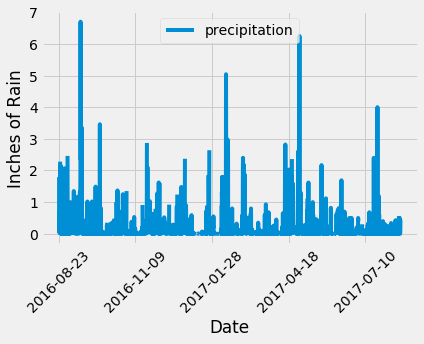

In [21]:
#GOAL: Design a query to retrieve the last 12 months of precipitation data and plot the results
#1: Calculate the date 1 year ago from the last data point in the database
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(last_date)
last_date_min1yr = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_date_min1yr)

date_query = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_date_min1yr).all()

#2: Perform a query to retrieve the data and precipitation scores
session.query(measurement.prcp, measurement.date).filter(measurement.date == date_query)
#3: Save the query results as a Pandas DataFrame and set the index to the date column
date_df = pd.DataFrame(date_query, columns=['date', 'precipitation'])
date_df.set_index(date_df['date'], inplace=True)
date_df = date_df.drop(columns=['date'])

#4: Sort the dataframe by date
date_df = date_df.sort_values("date")
#5: Use Pandas Plotting with Matplotlib to plot the data
date_df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Inches of Rain")
plt.xticks(rotation=45)
plt.savefig("12monthsraindata.png")

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(measurement.station).group_by(measurement.station).count()

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

### I couldn't get it to work with the order.

session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).all()

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [16]:
#columns
#station|name|latitude|longitude|elevation - hawaii_stations.csv
#station|date|prcp|tobs - hawaiimeasurements.csv

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs).filter(measurement.station == 'USC00519281')).all()

[(53.0, 87.0, 71.66378066378067)]

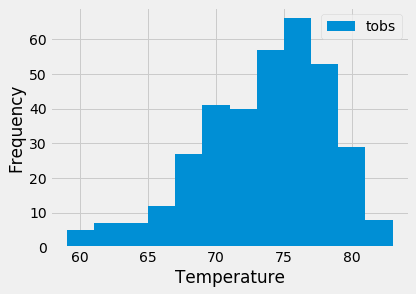

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
low_temp = session.query(measurement.tobs).filter(measurement.station == 'USC00519281').filter(measurement.date >= last_date_min1yr).all()

low_temp_df = pd.DataFrame(low_temp, columns=['tobs'])
low_temp_df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")

#tobs = time of observation bias?

plt.savefig("lowtempdata.png")